### Conversão do dataset de orientações (RGB -> skeleton -> graph)

In [1]:
import pickle
op_dic = pickle.load(open('db_skeleton', 'rb'))
len(op_dic)

4732

#### Exemplo de reconstrução (usando informações armazenadas)

In [2]:
img_folder = '../'

def str_construction(num):
    i_str = str(num)
    while len(i_str) < 5:
        i_str = '0' + i_str
    return img_folder + i_str + '.png'

##### Reutilização do objeto realPOSE (navSENSE)

In [3]:
import logging
import math
import numpy as np
import cv2
import networkx as nx
import pandas as pd
import itertools
from sklearn.metrics import pairwise_distances

class PYPoses:
    def __init__(self):
        self.logger = self.__create_logger__()

        self.points_dic = {0: "Nose", 1: "Neck", 2: "RShoulder", 3: "RElbow", 4: "RWrist", 5: "LShoulder",
                           6: "LElbow", 7: "LWrist", 8: "MidHip", 9: "RHip", 10: "RKnee", 11: "RAnkle",
                           12: "LHip", 13: "LKnee", 14: "LAnkle", 15: "REye", 16: "LEye", 17: "REar",
                           18: "LEar", 19: "LBigToe", 20: "LSmallToe", 21: "LHeel", 22: "RBigToe",
                           23: "RSmallToe", 24: "RHeel", 25: "Background"}

        self.pose_pairs = ((0, 1), (0, 15), (0, 16), (1, 2), (1, 5), (1, 8), (2, 3), (3, 4), (5, 6),
                           (6, 7), (8, 9), (8, 12), (9, 10), (10, 11), (11, 24), (11, 22), (12, 13),
                           (13, 14), (14, 19), (14, 21), (15, 17), (16, 18), (19, 20), (22, 23))
        
        self.pairs_labels = (0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1)

        self.joints = {'lshoulder': (1, 5, 6), 'rshoulder': (1, 2, 3), 'lelbow': (5, 6, 7), 'relbow': (2, 3, 4),
                       'lknee': (12, 13, 14), 'rknee': (9, 10, 11), 'lankle': (13, 14, 19), 'rankle': (10, 11, 22),
                       'lpelvis': (10, 9, 8), 'rpelvis': (13, 12, 8)}

    @staticmethod
    def __create_logger__():
        logger = logging.getLogger('TfPoseEstimatorRun')
        logger.handlers.clear()
        logger.setLevel(logging.DEBUG)
        ch = logging.StreamHandler()
        ch.setLevel(logging.DEBUG)
        formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
        ch.setFormatter(formatter)
        logger.addHandler(ch)
        return logger

    @staticmethod
    def __length_between_points__(p0, p1):
        return math.hypot(p1[0] - p0[0], p1[1] - p0[1])

    @staticmethod
    def __angle_between_points__(p0, p1, p2):
        a = (p1[0] - p0[0]) ** 2 + (p1[1] - p0[1]) ** 2
        b = (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2
        c = (p2[0] - p0[0]) ** 2 + (p2[1] - p0[1]) ** 2
        if a * b == 0:
            return -1.0
        return math.acos((a + b - c) / math.sqrt(4 * a * b)) * 180 / math.pi
    
    def __is_meaningful__(self, points: np.array) -> bool:
        found = False
        for pair in self.pose_pairs:
            partFrom = pair[0]
            partTo = pair[1]
            if points[partFrom] and points[partTo]:
                found = True
        return found
    
    def __get_angle_point__(self, human, pos):
        pos_list = self.joints[pos]
        pnts = []

        for i in range(3):
            if human[pos_list[i]][2] <= 0.1:
                print('component [%d] incomplete' % (pos_list[i]))
                return pnts

            pnts.append((int(human[pos_list[i]][0]), int(human[pos_list[i]][1])))
        return pnts

    def get_joint_angle(self, human, joint):
        pnts = self.__get_angle_point__(human, joint)
        if len(pnts) != 3:
            self.logger.info('component incomplete')
            return -1

        angle = 0
        if pnts is not None:
            angle = self.__angle_between_points__(pnts[0], pnts[1], pnts[2])
            self.logger.info('{} angle: {}'.format(joint, angle))
        return angle
    
    def get_points_dic(self):
        return self.points_dic

    def reconstruct_op(self, poseKeypoints, image, skeleton_mode='full', view_mode=True):
        if poseKeypoints.size < 3:
            return False, None
        else:
            skeletons = []
            for person in range(poseKeypoints.shape[0]):
                out = np.zeros_like(image)
                points = []
                for i in range(len(self.points_dic) - 1):
                    point = poseKeypoints[person][i, :2]
                    conf = poseKeypoints[person][i, 2]
                    x = int(point[0])
                    y = int(point[1])

                    # Add a point if it's confidence is higher than threshold.
                    points.append((int(x), int(y)) if conf > 0.3 else None)

                if skeleton_mode == 'partial':
                    partFrom = 1  # Neck
                    partTo = 8  # MidHip
                    if points[partFrom] and points[partTo]:
                        cv2.line(out, points[partFrom], points[partTo], (255, 255, 255), 2)
                        skeletons.append(cv2.cvtColor(out, cv2.COLOR_BGR2GRAY) != 0.)

                        if view_mode:
                            cv2.line(image, points[partFrom], points[partTo], (255, 74, 0), 2)
                            cv2.ellipse(image, points[partFrom], (1, 1), 0, 0, 360, (255, 255, 255), cv2.FILLED)
                            cv2.ellipse(image, points[partTo], (1, 1), 0, 0, 360, (255, 255, 255), cv2.FILLED)
                else:
                    for pair in self.pose_pairs:
                        partFrom = pair[0]
                        partTo = pair[1]

                        if points[partFrom] and points[partTo]:
                            cv2.line(out, points[partFrom], points[partTo], (255, 255, 255), 2)
                            if view_mode:
                                cv2.line(image, points[partFrom], points[partTo], (255, 74, 0), 2)
                                cv2.ellipse(image, points[partFrom], (1, 1), 0, 0, 360, (255, 255, 255), cv2.FILLED)
                                cv2.ellipse(image, points[partTo], (1, 1), 0, 0, 360, (255, 255, 255), cv2.FILLED)

                    skeletons.append(cv2.cvtColor(out, cv2.COLOR_BGR2GRAY) != 0.)

            if len(skeletons) > 0:
                return True, skeletons
            else:
                return False, None
            
    def create_graph(self, poseKeypoints):
        if poseKeypoints.size < 3:
            return False, None
        else:
            G = []
            for person in range(poseKeypoints.shape[0]):
                points = []
                for i in range(len(self.points_dic) - 1):
                    point = poseKeypoints[person][i, :2]
                    conf = poseKeypoints[person][i, 2]
                    x = int(point[0])
                    y = int(point[1])

                    # Add a point if it's confidence is higher than threshold.
                    points.append((int(x), int(y)) if conf > 0.3 else None)
                    
                graph = nx.Graph()
                labels = {}
                
                for pair in self.pose_pairs:
                    partFrom = pair[0]
                    partTo = pair[1]

                    if points[partFrom] and points[partTo]:
                        graph.add_edge(self.points_dic[partFrom], self.points_dic[partTo], 
                        weight=self.__length_between_points__(points[partFrom], points[partTo]))
                        labels[self.points_dic[partFrom]] = partFrom
                        labels[self.points_dic[partTo]] = partTo
                
                if graph.size() > 0:
                    nx.set_node_attributes(graph, labels, 'label')
                    G.append(graph)
                    
            if len(G) > 0:
                return True, G
            else:
                return False, None
            
    def empty_dataframe(self):
        columns = ['{}-{}'.format(self.points_dic[p1],self.points_dic[p2]) for p1, p2 in self.pose_pairs]
        [columns.append(j) for j in self.joints.keys()]
        columns.append('label')
        return pd.DataFrame(columns=columns)
    
    def large_empty_dataframe(self):
        point_comb = list(itertools.combinations(range(25), 2))
        joint_comb = list(itertools.combinations(range(25), 3))
        points = ['{}-{}'.format(self.points_dic[p1],self.points_dic[p2]) for p1, p2 in point_comb]
        joints = ['{}-{}-{}'.format(self.points_dic[p1],self.points_dic[p2],self.points_dic[p3]) for p1,p2,p3 in joint_comb]
        columns = points+joints
        columns.append('label')
        return pd.DataFrame(columns=columns)
            
    def create_pandas_frames(self, poseKeypoints, df, metric):
        if poseKeypoints.size < 3:
            return False, None
        
        def built_person(person):
            points = []
            for i in range(len(self.points_dic) - 1):
                point = person[i, :2]
                conf = person[i, 2]
                x = int(point[0])
                y = int(point[1])

                # Add a point if it's confidence is higher than threshold.
                points.append((int(x), int(y)) if conf > 0.3 else None)

            sk_dict = dict(zip(df.columns, np.full(len(df.columns), np.nan)))
            found = False

            for pair in self.pose_pairs:
                partFrom = pair[0]
                partTo = pair[1]

                if points[partFrom] and points[partTo]:
                    key = '{}-{}'.format(self.points_dic[partFrom],self.points_dic[partTo])
                    p1, p2 = np.asarray(points[partFrom]).reshape(1,2), np.asarray(points[partTo]).reshape(1,2)
                    val = pairwise_distances(p1, p2, metric=metric).mean()
                    sk_dict[key] = val
                    found = True

            for key, val in self.joints.items():
                p0, p1, p2 = val
                if points[p0] and points[p1] and points[p2]:
                    ang = self.__angle_between_points__(points[p0],points[p1],points[p2])
                    sk_dict[key] = ang
                        
            return found, sk_dict
             
        valid = 0
        
        if poseKeypoints.shape[0] == 1:
            found, sk_dict = built_person(poseKeypoints[0])
            if found:
                df.loc[len(df)] = sk_dict
                valid += 1
                
        elif poseKeypoints.shape[0] == 25:
            found, sk_dict = built_person(poseKeypoints)
            if found:
                df.loc[len(df)] = sk_dict
                valid += 1
        else:
            for person in poseKeypoints:
                found, sk_dict = built_person(person)
                if found:
                    df.loc[len(df)] = sk_dict
                    valid += 1

        if valid > 0:
            return True, valid
        else:
            return False, None
            
    def create_large_pandas_frames(self, poseKeypoints, df, metric):
        if poseKeypoints.size < 3:
            return False, None
        
        def built_person(person):
            points = []
            for i in range(len(self.points_dic) - 1):
                point = person[i, :2]
                conf = person[i, 2]
                x = int(point[0])
                y = int(point[1])

                # Add a point if it's confidence is higher than threshold.
                points.append((int(x), int(y)) if conf > 0.3 else None)

            sk_dict = dict(zip(df.columns, np.full(len(df.columns), np.nan)))
            found = False

            if not self.__is_meaningful__(points):
                pass
            else:
                point_comb = list(itertools.combinations(range(25), 2))
                joint_comb = list(itertools.combinations(range(25), 3))

                for pair in point_comb:
                    partFrom = pair[0]
                    partTo = pair[1]

                    if points[partFrom] and points[partTo]:
                        key = '{}-{}'.format(self.points_dic[partFrom],self.points_dic[partTo])
                        p1, p2 = np.asarray(points[partFrom]).reshape(1,2), np.asarray(points[partTo]).reshape(1,2)
                        val = pairwise_distances(p1, p2, metric=metric).mean()
                        sk_dict[key] = val
                        found = True

                for val in joint_comb:
                    p0, p1, p2 = val
                    if points[p0] and points[p1] and points[p2]:
                        ang = self.__angle_between_points__(points[p0],points[p1],points[p2])
                        key = '{}-{}-{}'.format(self.points_dic[p0], self.points_dic[p1], self.points_dic[p2])
                        sk_dict[key] = ang
                
            return found, sk_dict
            
        valid = 0
        
        if poseKeypoints.shape[0] == 1:
            found, sk_dict = built_person(poseKeypoints[0])
            if found:
                df.loc[len(df)] = sk_dict
                valid += 1
                
        elif poseKeypoints.shape[0] == 25:
            found, sk_dict = built_person(poseKeypoints)
            if found:
                df.loc[len(df)] = sk_dict
                valid += 1
        else:
            for person in poseKeypoints:
                found, sk_dict = built_person(person)
                if found:
                    df.loc[len(df)] = sk_dict
                    valid += 1
            
        if valid > 0:
            return True, valid
        else:
            return False, None

##### Visualização

,Nose-Neck,Nose-RShoulder,Nose-RElbow,Nose-RWrist,Nose-LShoulder,Nose-LElbow,Nose-LWrist,Nose-MidHip,Nose-RHip,Nose-RKnee,...,LSmallToe-LHeel-RSmallToe,LSmallToe-LHeel-RHeel,LSmallToe-RBigToe-RSmallToe,LSmallToe-RBigToe-RHeel,LSmallToe-RSmallToe-RHeel,LHeel-RBigToe-RSmallToe,LHeel-RBigToe-RHeel,LHeel-RSmallToe-RHeel,RBigToe-RSmallToe-RHeel,label
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,78.550662,83.990994,159.443955,137.121096,60.255119,135.000000,71.565051,12.994617,45.000000,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,75.963757,74.054604,135.000000,90.000000,7.125016,143.130102,98.130102,14.036243,45.000000,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,177.510447,117.758541,177.397438,60.832387,54.685522,177.137595,60.572544,54.486580,56.976132,NaN
3,1.993044,1.142967,NaN,NaN,1.718987,NaN,NaN,0.824585,1.720799,1.930393,...,52.125016,53.130102,133.228530,38.829825,15.843082,118.988823,24.590117,1.930587,53.841815,NaN
4,0.873240,2.281593,NaN,NaN,1.345039,0.609033,1.353862,2.571093,1.948800,0.795107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,133.122123,133.347695,125.537678,91.847610,11.309932,135.000000,101.309932,1.301953,33.690068,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,53.130102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


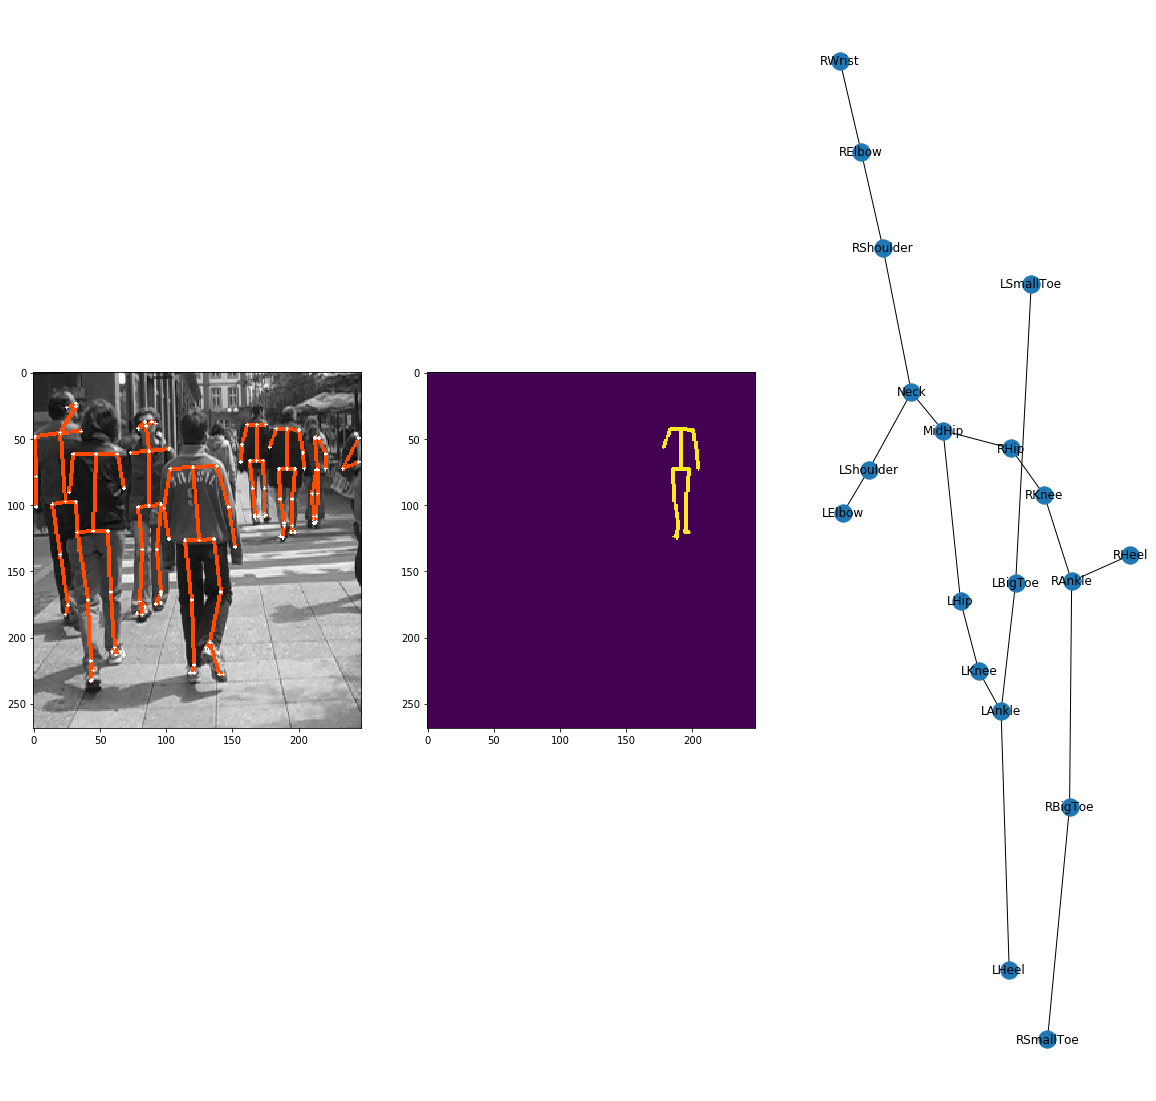

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

id_img = 1325
op = PYPoses()
raw_skeleton = op_dic[id_img]
raw_img = cv2.imread(str_construction(id_img))

bool_sk, skeleton = op.reconstruct_op(raw_skeleton, raw_img)
bool_gr, graph = op.create_graph(raw_skeleton)

plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(raw_img)

show_id = 0
if bool_sk and bool_gr:
    plt.subplot(132)
    plt.imshow(skeleton[show_id])
    plt.subplot(133)
    nx.draw(graph[show_id], with_labels=True)

df = op.large_empty_dataframe()
op.create_large_pandas_frames(raw_skeleton, df, 'haversine')
df.head(10)

#### Tratamento de amostras com multiplas pessoas (orientações diferentes) 

In [5]:
import xml.etree.ElementTree as ET

annotation_folder = '../../viewpoints_train'

def annotation_db(file):
    tree = ET.parse(file)
    root = tree.getroot()
    
    dic = {}
    for annon in root.findall('annotation'):
        img_name = annon.find('image')
        rect = annon.findall('annorect')
        n = img_name.find('name').text.split('/')[1]
        n = int(n.split('.')[0])
        nums = []
        diverge = None
        for sillh in rect:
            label = sillh.findall('silhouette')
            diff = sillh.findall('diff')
            if diff is not None:
                for df in diff:
                    fdp_pos = int(df.find('id').text)
                    fdp_silh = int(df.find('sl').text)
                    diverge = (fdp_pos, fdp_silh)
            for id_ in label:
                nums.append(int(id_.find('id').text))
        if diverge is not None:
            nums = (nums, diverge)
        dic[n] = nums
        
    return dic
        
    
graph_dic = {}
for i in range(1,9):
    graph_dic.update(annotation_db(annotation_folder+'{}.al'.format(i)))

filename = 'annotation_dic'
outfile = open(img_folder+filename, 'wb')
pickle.dump(graph_dic, outfile)
outfile.close()

#### Rotulação

In [6]:
import pickle

def label_conversor(label, sk_num):
    if type(label) == list:
        if len(label) == sk_num:
            return label
        elif len(label) == 1:
            return np.ones(sk_num, dtype=int)*label[0]
    elif type(label) == tuple:
        slh_common, slh_diff = label
        rt = np.ones(sk_num, dtype=int)*slh_common[0]
        rt[slh_diff[0]] = slh_diff[1]
        return rt

def graph_create():
    gx_train = []
    yx_train = []

    for k in graph_dic.keys():
        _, sk = op.create_graph(op_dic[k])
        for skeleton in sk:
            gx_train.append(skeleton)
        labels = label_conversor(graph_dic[k], len(sk))
        for l in labels:
            yx_train.append(l)

def df_create():
    yx = []
    sk_num = []
    df = op.large_empty_dataframe()
    
    for k in graph_dic.keys():
        print(k)
        _, num = op.create_large_pandas_frames(op_dic[k], df, 'braycurtis')
        labels = label_conversor(graph_dic[k], num)
        sk_num.append(len(labels))
        for l in labels:
            yx.append(l)
        
    df['label'] = yx
    return df, sk_num

df, sk_num = df_create()
df.head()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


,Nose-Neck,Nose-RShoulder,Nose-RElbow,Nose-RWrist,Nose-LShoulder,Nose-LElbow,Nose-LWrist,Nose-MidHip,Nose-RHip,Nose-RKnee,...,LSmallToe-LHeel-RSmallToe,LSmallToe-LHeel-RHeel,LSmallToe-RBigToe-RSmallToe,LSmallToe-RBigToe-RHeel,LSmallToe-RSmallToe-RHeel,LHeel-RBigToe-RSmallToe,LHeel-RBigToe-RHeel,LHeel-RSmallToe-RHeel,RBigToe-RSmallToe-RHeel,label
0,0.111111,0.121495,0.237537,0.278947,0.094225,NaN,NaN,0.252577,0.262338,0.327146,...,165.963757,146.510969,163.300756,115.327025,103.256128,167.926169,119.952438,108.019769,118.511246,1
1,0.080000,0.086860,0.183406,0.263598,0.072848,0.125773,0.125984,0.207101,0.207101,0.221053,...,9.611690,2.882518,31.790290,31.304744,32.926433,34.267335,33.781790,35.172914,179.383940,1
2,0.075397,0.081511,0.162524,0.217391,0.065089,0.123389,0.116608,0.183746,0.177504,0.202552,...,53.428455,49.617614,67.520566,6.811928,2.643073,79.380345,18.671707,14.419093,113.702646,1
3,0.073359,0.066922,0.129964,0.153457,0.077519,NaN,NaN,0.174439,0.176471,0.219745,...,2.993724,13.484677,37.785738,21.023183,23.035044,41.794784,25.032230,24.991593,159.253920,1
4,0.063516,0.051395,0.088398,0.107570,0.071429,0.141606,0.193033,0.139756,0.142469,0.226913,...,179.687859,172.042792,174.472460,144.403877,134.569213,174.447029,144.378446,134.635451,139.763642,1


In [14]:
outfile = open('orientation_df_train', 'wb')
pickle.dump(df, outfile)
outfile.close()

#### Reproducing HOG experiment

In [7]:
train_pos_ord = {1:(1,400), 2:(401,1149), 3:(1150,1793), 4:(1794,2542),
                 5:(2543,2942), 6:(2943,3564), 7:(3565,4110), 8:(4111,4732)}
out, loc = 0, 0
df_hoc = op.large_empty_dataframe()
for now, step in enumerate(sk_num):
    check = df[loc:loc+step]
    for k, v in train_pos_ord.items():
        if v[0] <= now <= v[1]:
            out = k
            break
    check.where(check['label'] == out )
    df_hoc.loc[len(df_hoc)] = check.iloc[0]
    loc += step

In [15]:
outfile = open('simple_df_train', 'wb')
pickle.dump(df_hoc, outfile)
outfile.close()

In [8]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

hoc_X, hoc_y = df_hoc.iloc[:,:-1], df_hoc.iloc[:,-1]
eval_metric = ["auc","error"]
classifier = xgb.XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.1,  
                      colsample_bytree = 0.8,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=0.1)

%time classifier.fit(hoc_X, hoc_y, eval_metric=eval_metric, verbose=True)

Wall time: 1h 30min 30s


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0.3,
              reg_lambda=1, scale_pos_weight=1, silent=False, subsample=0.8,
              tree_method=None, validate_parameters=False, verbosity=None)

In [9]:
optest_dic = pickle.load(open('db_skeleton_test', 'rb'))

def find_skeleton(rectangle, sk_array):
    x1, y1, x2, y2 = rectangle
    for sk in sk_array:
        for point in sk:
            x, y, c = point
            if c > 0.3:
                if not ((x1 <= x <= x2) and (y1 <= y <= y2)):
                    break
        return sk

annotation_test_folder = '../../viewpoints_test.al'
tree = ET.parse(annotation_test_folder)
root = tree.getroot()

df_hoc_test = op.large_empty_dataframe()

for step, annon in enumerate(root.findall('annotation')):
    img_name = annon.find('image')
    rect = annon.findall('annorect')
    n = img_name.find('name').text.split('/')[1]
    n = int(n.split('.')[0])

    for sillh in rect:
        label = sillh.findall('silhouette')
        x1, x2, = sillh.find('x1').text, sillh.find('x2').text
        y1, y2 = sillh.find('y1').text, sillh.find('y2').text 
        
        for id_ in label:
            id_ = int(id_.find('id').text)

    sk = find_skeleton(tuple(map(int,(x1,y1,x2,y2))), optest_dic[n])
    print(n)
    _, num = op.create_large_pandas_frames(sk, df_hoc_test, 'braycurtis')
    df_hoc_test.loc[len(df_hoc_test)-1, 'label'] = int(id_)

df_hoc_test.head()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248


,Nose-Neck,Nose-RShoulder,Nose-RElbow,Nose-RWrist,Nose-LShoulder,Nose-LElbow,Nose-LWrist,Nose-MidHip,Nose-RHip,Nose-RKnee,...,LSmallToe-LHeel-RSmallToe,LSmallToe-LHeel-RHeel,LSmallToe-RBigToe-RSmallToe,LSmallToe-RBigToe-RHeel,LSmallToe-RSmallToe-RHeel,LHeel-RBigToe-RSmallToe,LHeel-RBigToe-RHeel,LHeel-RSmallToe-RHeel,RBigToe-RSmallToe-RHeel,label
0,0.063232,0.056604,0.118943,0.134066,0.069767,0.134199,0.188641,0.166667,0.168399,0.243856,...,NaN,178.639311,NaN,170.776078,NaN,NaN,170.695228,NaN,NaN,5.0
1,0.035294,0.029586,NaN,NaN,0.035294,0.054755,0.090379,0.098901,0.096419,0.143603,...,145.459909,146.546691,126.469234,164.344218,174.559668,135.000000,172.874984,176.423666,135.000000,5.0
2,0.093985,0.127907,0.236842,0.280000,0.063985,NaN,0.187117,0.228800,0.259016,0.334333,...,104.883215,155.308442,175.894901,150.781836,139.162435,113.198591,79.875328,92.774920,135.946951,1.0
3,0.081967,0.057692,0.122172,0.164882,0.096774,0.164179,0.201629,0.191753,0.176471,0.234375,...,38.844832,24.725620,41.905942,1.669584,0.000000,26.939528,13.296830,16.460015,135.000000,5.0
4,0.043478,0.067416,0.128342,0.193798,0.076115,NaN,NaN,0.142857,0.162907,0.227907,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [16]:
outfile = open('simple_df_test', 'wb')
pickle.dump(df_hoc_test, outfile)
outfile.close()

In [10]:
from sklearn.metrics import classification_report

hoc_test_X, hoc_test_y = df_hoc_test.iloc[:,:-1], df_hoc_test.iloc[:,-1]
hoc_pred_y = classifier.predict(hoc_test_X)

print(classification_report(hoc_test_y, hoc_pred_y, digits=3))

              precision    recall  f1-score   support

         1.0      0.929     0.500     0.650        26
         2.0      0.607     0.895     0.723        19
         3.0      0.881     0.902     0.892        41
         4.0      0.805     0.868     0.835        38
         5.0      0.933     0.609     0.737        23
         6.0      0.872     0.919     0.895        37
         7.0      0.854     0.897     0.875        39
         8.0      0.786     0.880     0.830        25

    accuracy                          0.827       248
   macro avg      0.833     0.809     0.805       248
weighted avg      0.843     0.827     0.822       248



Distribuição das amostras por classe
4.0    766
2.0    754
7.0    735
6.0    617
8.0    589
3.0    480
1.0    399
5.0    392
Name: label, dtype: int64
Tipos
              precision    recall  f1-score   support

         1.0      0.929     0.500     0.650        26
         2.0      0.607     0.895     0.723        19
         3.0      0.881     0.902     0.892        41
         4.0      0.805     0.868     0.835        38
         5.0      0.933     0.609     0.737        23
         6.0      0.872     0.919     0.895        37
         7.0      0.854     0.897     0.875        39
         8.0      0.786     0.880     0.830        25

    accuracy                          0.827       248
   macro avg      0.833     0.809     0.805       248
weighted avg      0.843     0.827     0.822       248



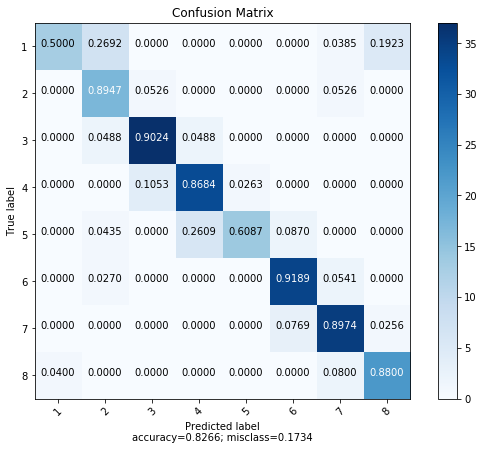

Text(0, 0.5, 'Feature Importance Score')

<Figure size 432x288 with 0 Axes>

<Figure size 720x432 with 0 Axes>

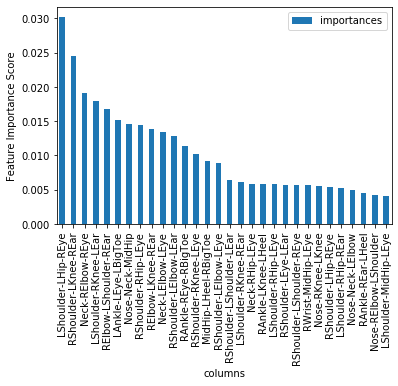

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig("Confusion Matrix.png", dpi=300, bbox_inches='tight')
    plt.show()

print('Distribuição das amostras por classe')
print(df_hoc.label.value_counts())
print('Tipos')
hoc_X.dtypes

print(classification_report(hoc_test_y, hoc_pred_y, digits=3))
report = 'Results for {} \n'.format('metric')
report += classification_report(hoc_test_y, hoc_pred_y, digits=3)
report += '\n \n'

plot_confusion_matrix(cm           = confusion_matrix(hoc_test_y, hoc_pred_y),
                      normalize    = True,
                      target_names = [1,2,3,4,5,6,7,8],
                      title        = 'Confusion Matrix')

plt.tight_layout()
plt.figure(figsize=(10, 6))
results=pd.DataFrame()
results['columns']=hoc_test_X.columns
results['importances'] = classifier.feature_importances_
results.sort_values(by='importances',ascending=False,inplace=True)

results[:30].plot(kind='bar', x='columns')
plt.ylabel('Feature Importance Score')

In [28]:
outfile = open('features_importance_df', 'wb')
pickle.dump(results, outfile)
outfile.close()

#### Treinamento

In [12]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

dataset = df.sample(frac=1, random_state=123)
X, y = dataset.iloc[:,:-1], dataset.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

eval_metric = ["auc","error"]
classifier = xgb.XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.1,  
                      colsample_bytree = 0.8,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=0.1)

%time classifier.fit(X_train, y_train, eval_metric=eval_metric, verbose=True)
y_pred = classifier.predict(X_test)

Wall time: 2h 33min 27s


#### Validação Cruzada

In [13]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(classifier, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

KeyboardInterrupt: 

#### Resultados

In [ ]:
print('Distribuição das amostras por classe')
print(dataset.label.value_counts())
print('Tipos')
dataset.dtypes

print(classification_report(y_test, y_pred, digits=3))
report = 'Results for {} \n'.format('metric')
report += classification_report(y_test, y_pred, digits=3)
report += '\n \n'

with open('out.txt', 'a+') as f:
    for line in report.split('\n'):
        f.write(line+'\n')
    f.close()

plot_confusion_matrix(cm           = confusion_matrix(y_test, y_pred),
                      normalize    = True,
                      target_names = [1,2,3,4,5,6,7,8],
                      title        = 'Confusion Matrix')

plt.tight_layout()
plt.figure(figsize=(10, 6))
feat_imp = pd.Series(classifier.feature_importances_, index=X_test.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

plt.savefig("Feature_Importance_Score.png", dpi=300, bbox_inches='tight')
print(dataset.shape)